<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_10_2024_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Week 10 Practical: Relighting using the reflectance field.

This week you are going to simulate the Light Stage (see Debevec et al, 2000) using Mitsuba.

For an overview, please refer to the video "Week 10 - Practical (Reflectance Field and Relighting)" and the corresponding slides.

Your subject will be the [monkey Suzanne](https://www.dummies.com/article/technology/software/animation-software/blender/meet-suzanne-the-blender-monkey-142918/).


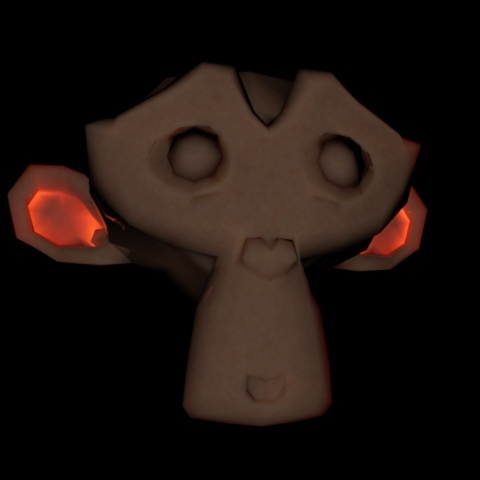


[This video](https://www.dropbox.com/s/wacmvodo581nat6/suzanne_VICO_Week_10.avi) shows how Suzanne would appear during a typical Light Stage acquisition session. The video has been obtained by putting together the images rendered in task 1.

# Part 1 (Tasks 1-5)

##Task 1. Dataset rendering

We will use this scene ([rar](https://www.dropbox.com/s/ojepdk7tt1k6kp6/practical_Summer_week3.rar), [zip](https://www.dropbox.com/s/y42tidf51f2yaze/practical_Summer_week3.zip)) for our renderings. The xml code already specifies the camera position (fixed), the location of the object and the skin material, defined in terms of per-channel absorption and scattering coefficients ($\sigma_a$ and $\sigma_s$), derived from measured skin data.
The skin model is rather simplistic, since it assumes skin to be a single layered, homogeneous medium.

Two different sets of skin parameter values are included in the xml file (skin type 1 and skin type 2, the only two sets of measured values available in the Mitsuba documentation).
If you wish to change the skin colour beyond the two samples provided, try playing a bit with absorption and scattering, accountig for the fact that darker skin has higher absorption than lighter skin tones, and all skin types have higher absorption in the blue and green channels than in the red one.

To lit the subject, we will use a directional light. Since we want to simulate the behaviour of the 1999 Light Stage, the location of the light will sample an imaginary sphere (radius 1000 in the scene units). For each location of the light, you will render an image.

**Please note**: *Mitsuba requires that you specify the direction of the light, rather than its location. Given that the subject is placed at the origin of the coordinate system, you will need to compute the desired location of the light over the sphere, and then invert the sign of $x,y,z$ to get the direction.*

To speedup the rendering process, you should use Mitsuba command line interface (see the [manual](https://www.mitsuba-renderer.org/releases/current/documentation_lowres.pdf), in particular 5.2.2 "Passing parameters") to pass the parameters and render the images.

For example, let's say light number 30 needs to have a direction equal to ```x=-100, y=75, z=992 ```. Then you should type something like (depending on path and OS):

`$ mitsuba -DlightX=-100 -DlightY=75 -DlightZ=992 -o light_ID_30.exr Vico_WeeK3Summer_Suzanne_LS.xml`

The above would also save the rendering in exr format (with filename "light_ID_30.exr")

For this task, use a coarse angular resolution $\phi \times \theta$, such as $12 \times 24$.

**Please note**: Since rendering all the images will take some time, for the lab session you could skip the rendering element of this task and simply generate the coordinates of the lights:

*   You can download the rendered images, already tonemapped and saved as png files, from [this link](https://www.dropbox.com/s/5kopjypnnjophao/suzanne1_png.zip) (skin type 1) or [this link](https://www.dropbox.com/s/ielboy7pb6bx3f4/suzanne_png.zip) (skin type 2).
*   **The EXR images, used in the following tasks, are available** [here](https://www.dropbox.com/s/4cp80kwxex084gl/suzanne1_exr.zip) (skin type 1) and [here](https://www.dropbox.com/s/20zl8rk4v1drbor/Suzanne2_EXR.zip) (skin type 2).

Then, focus on the relighting technique (Task 2 and following ones).







phi values:  [  0.          16.36363636  32.72727273  49.09090909  65.45454545
  81.81818182  98.18181818 114.54545455 130.90909091 147.27272727
 163.63636364 180.        ]
theta values:  [  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165. 180. 195.
 210. 225. 240. 255. 270. 285. 300. 315. 330. 345.]


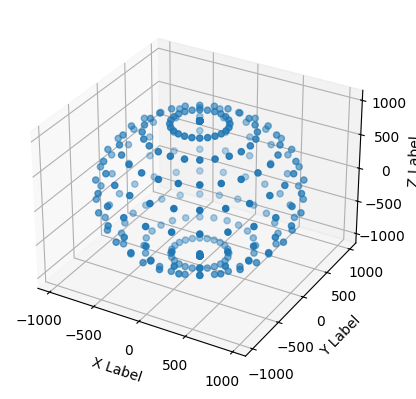

In [5]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import numpy as np
import matplotlib.pyplot as plt
import cv2

# let's define the angular resolution and radius of the (virtual) Light Stage sphere
phi_samples = 12;
theta_samples = 24;
radius = 1000

# let's uniformly sample phi and theta
phi = np.linspace(0, np.pi, phi_samples)
theta = np.linspace(0, 2 * np.pi-(2 * np.pi/theta_samples), theta_samples)

print("phi values: ", np.rad2deg(phi))
print("theta values: ", np.rad2deg(theta))

# now generate the x, y and z coordinates of the lights over the sphere.
# Each coordinate should be stored in a 2D matrix, so that it can be indexed using the appropria phi and theta values.
# Have a look at a couple of code cells down, where the coordinates are saved in a text file, to see the indended usage.
# To complete the following lines of code, consider using np.outer(*,*) and np.ones_like(*)
x = radius * np.outer(np.sin(phi), np.cos(theta))
y = radius * np.outer(np.sin(phi), np.sin(theta))
z = radius * np.outer(np.cos(phi), np.ones_like(theta))

# let's plot the locations of the lights over the sphere
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [6]:
# Compare the coordinate system of the plot in the above with the coordinate system used by Mitsuba: make sure you convert the coordinates accordingly!

tmp = y
y = z
z = -tmp

# Once you have converted the coordinates, pay attention to what mentioned in the task description: we are using directional lights, which in Mitsuba need to be specified in terms of the direction of the beam, rather than the location of the light.
# Accounting for the above is very simple: think of the location over the sphere as a vector, then invert its direction.

x = -x
y = -y
z = -z



In [7]:
# At this point, we could/should write a script that would allow us to use the lighting directions generated in the above and render all the images, without even opening the Mitsuba GUI.
# For example, in Windows this can be done by saving each command line it a BAT files and running it from the command prompt.

script_file = open("Mitsuba_script.bat", "w")

light_index = 0

for phi_index in range(phi_samples):
  for theta_index in range(theta_samples):
    render_line = "mitsuba.exe -DlightX={} -DlightY={} -DlightZ={} -o light_ID_{}.exr Vico_WeeK3Summer_Suzanne_LS.xml \n".format(x[phi_index][theta_index], y[phi_index][theta_index], z[phi_index][theta_index], str(light_index).zfill(3))
    script_file.write(render_line)
    #optionally, you could use mtsutil to tonemap the images.
    tonemap_line = "mtsutil.exe tonemap light_ID_{}.exr \n".format(str(light_index).zfill(3))
    script_file.write(tonemap_line)
    light_index += 1

script_file.close()

##Task 2. Reflectance functions

Once you have rendered the dataset, use Colab to compute the reflectance maps.

You could use a mask to ignore the background pixels, as they do not need a reflectance map. However, including background pixels in the computation (as done in the following), is not really a problem, except for the incresed computational cost.

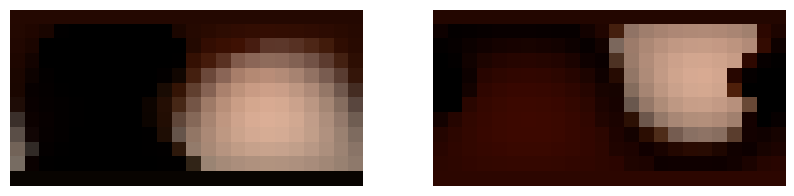

In [9]:
# upload the rendered images!


#we will store the reflectance maps in the variable reflectance_maps. Each pixel will have a map, with the angular resolution we have previously set
#The following code creates reflectance maps for the background pixels too, but they could be skipped.
light_index = 0

img = cv2.cvtColor(cv2.imread("light_ID_000.exr".format(str(light_index).zfill(3)), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH),cv2.COLOR_BGR2RGB)
reflectance_maps = np.zeros((img.shape[0]*img.shape[1],phi_samples,theta_samples,3))

# read each image and arrange its pixels in order to create the reflectance maps
for phi_index in range(phi_samples):
  for theta_index in range(theta_samples):
    img = cv2.cvtColor(cv2.imread("light_ID_{}.exr".format(str(light_index).zfill(3)), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH),cv2.COLOR_BGR2RGB)

    #at this point, you need to create the reflectance maps, starting from the pixel values

    for ch in range(3):
      pixels_channel = np.reshape(img[:,:,ch], (img.shape[0]*img.shape[1]));
      reflectance_maps[:,phi_index,theta_index,ch]=pixels_channel;

    light_index += 1

# let's visualise a couple of reflectance maps, gamma corrected (using the approximate sRGB gamma)
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(reflectance_maps[71470]**(1/2.2))
axes[1].imshow(reflectance_maps[61601]**(1/2.2))
axes[0].axis('off')
axes[1].axis('off')
plt.show()




##Task 3. Relighting

Downsample the provided environment map at the same resolution of the reflectance maps, then perform the relighting. Don't forget to correct for the different numbers of samples per solid angle, which depends on $\phi$!

--2024-12-29 19:06:24--  https://www.dropbox.com/s/l1z9huqcug6jcob/envmap.exr
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/zmf7imzb6jhim177bqruy/envmap.exr?rlkey=mcvnnb6ky7t29e1t851pfwhsf [following]
--2024-12-29 19:06:24--  https://www.dropbox.com/scl/fi/zmf7imzb6jhim177bqruy/envmap.exr?rlkey=mcvnnb6ky7t29e1t851pfwhsf
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0703527e1201acd1ea57b7556a.dl.dropboxusercontent.com/cd/0/inline/ChNrpqeHzwskdEqixJe9Hvow_OdFO6eCTvI8Wutlc6oN8V3wEcHXc5sG10Oik33nn0wp_drXdctvQZNGPwZkvQpCEXsnRub7EHCn316e6PyljNdFgUD4vQWiyEmCdAdB5Df79X2t61QBvdDTYNz1GKaU/file# [following]
--2024-12-29 19:06:24--  https://uc0703527e1201acd1ea57b7556a.dl.dropboxusercontent.com/cd/0/inline/ChNrpqe

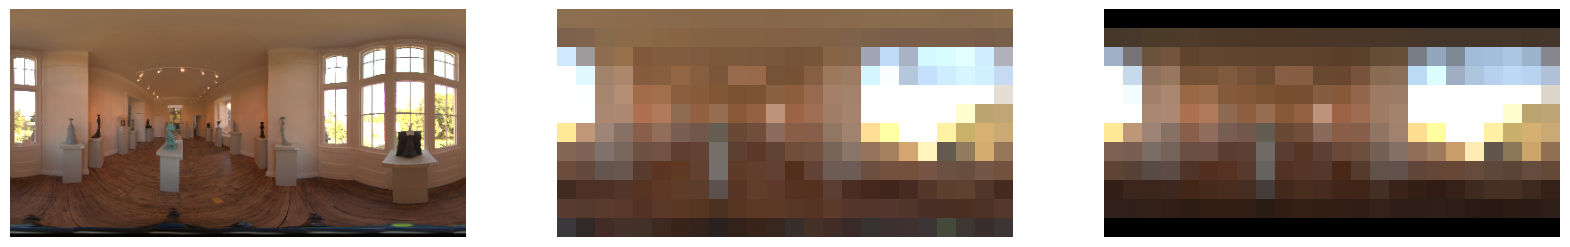

In [10]:
!wget https://www.dropbox.com/s/l1z9huqcug6jcob/envmap.exr

# load and resize the environment map at the desired angular resoltion
envmap = cv2.cvtColor(cv2.imread("envmap.exr", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH),cv2.COLOR_BGR2RGB)
envmap_resized = cv2.resize(envmap, (theta_samples,phi_samples), interpolation = cv2.INTER_AREA)

# we need to correct for the solid angle, that is, for the sin(phi)
correction_map = np.zeros((phi_samples,theta_samples))
envmap_corrected = np.zeros((phi_samples,theta_samples,3))

# fill the correction map with the appropriate values, then use it to correct the environment map

for phi_index in range(phi_samples):
  correction_map[phi_index] = np.sin(phi[phi_index])

for ch in range(3):
  envmap_corrected[:,:,ch] = envmap_resized[:,:,ch] * correction_map

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(envmap**(1/2.2))
axes[1].imshow(envmap_resized**(1/2.2))
axes[2].imshow(envmap_corrected**(1/2.2))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.show()

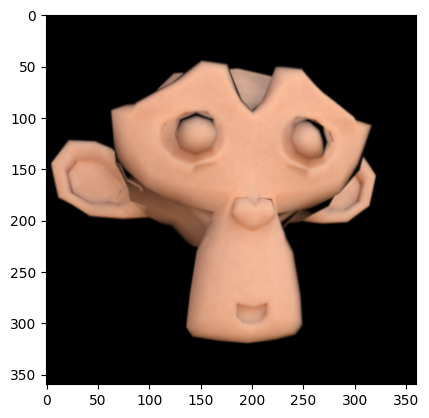

In [12]:
#Now it's time to perform the relighting, using the reflectance maps and the corrected environment map lighting

# here we will store the final image
relit_image = (np.zeros((img.shape[0],img.shape[1],3))).astype(np.float32)

# this matrix will store the production between the reflectance map and the downsampled, corrected lighting
relit_map = (np.zeros((phi_samples,theta_samples))).astype(np.float32)

pixel_id = 0
for i in range(len(relit_image)):
  for j in range(len(relit_image[i])):
    for ch in range(3):
      relit_map = reflectance_maps[pixel_id, :,:, ch] * envmap_corrected[:,:,ch]
      relit_image[i][j][ch] = np.sum(relit_map)
    pixel_id += 1

#before visualising the resulting image, we should tonemap it or rescale it in the range [0-1]. Otherwise, it could appear saturated
tonemapper = cv2.createTonemap(gamma=2.2)
img_tonemapped = tonemapper.process(relit_image.copy())
plt.imshow(img_tonemapped)


##Task 4. Try other environment maps!

We can now use any other environment map to perform the relighting, without having to recompute the reflectance maps.
For example, we could use the "Grace Cathedral" available at https://vgl.ict.usc.edu/Data/HighResProbes/. Have a try with the other available maps and compare Suzanne's appearance under different environment maps.

In [ ]:
!wget https://www.dropbox.com/s/qi6dgf3vu4whh9a/grace-new.exr

# your code goes here (mostly code reused from previous cells)

##Task 5. Environment map rotation

You can now easily rotate the environment map illumination around the subject, give it a try!

In [ ]:
# The rotatation of the environment map around the subject is typically done around the vertical axis (as this keeps the ceiling / sky, etc at the top!).

# your code goes here



---


#Part 2: Photometric stereo from rendered images (optional).
In [Practical Week 6](https://colab.research.google.com/drive/1PlyecDr5Hf3mT1SQ6gKAcBJrzUjoZ1Tj?usp=sharing) (Task 2), I mentioned that once you learned about photometric stereo, this technique could be used to compute the normal map of the sphere needed for the MatCap rendering. Now that you have the tools and knowledge, you can try it out!

##Task 6. Sphere normal map from photometric stereo (optional).

For this task, you can reuse the set of light coordinates (with a caveat, as mentioned in the next paragraph) used for the Week 9 practical (or a reasonably large subset). Set the material of the sphere as a perfect diffuse reflector with $\rho_d=0.5$, and set the intensity of the light to 1000 units of power per steradian.

The light coordinates will need to be scaled by a factor of 10 to account for the scale of the scene: the default Mitsuba sphere has a radius equal to 1. Therefore, most light coordinates from Week 9 would fall inside the sphere if their coordinates are left unscaled! In the file provided in Week 9 (file PSData.zip), lights are arranged in columns, where the first row corresponds to the $x$-coordinate in the Mitsuba coordinate system, $y$ to the second row, $z$ to the third row.  

Once you have rendered the images, you can reuse the solution from [Week 9 practical](https://colab.research.google.com/drive/1KI53oTt7OQAqdQw52iNTKHBCEDAg3-3A?usp=sharing) to obtain the normal map for the sphere. The mask can be found in the solution of Week 6 Practical.

